The Kalman filter estimates time-varying exposures from noisy returns using a linear Gaussian state-space model. Let:

---

**Model Dimensions and Notation**

- $\beta_t \in \mathbb{R}^{K \times 1}$ — latent exposures to $K$ risk factors at time $t$
- $y_t \in \mathbb{R}^{1 \times 1}$ — observed return fund at time $t$
- $H_t \in \mathbb{R}^{1 \times K}$ — row vector of factor/benchmark returns at time $t$
- $T \in \mathbb{R}^{K \times K}$ — transition matrix (often $T = I_K$ for a random walk)
- $Q \in \mathbb{R}^{K \times K}$ — covariance of state (exposure) noise
- $R \in \mathbb{R}^{1 \times 1}$ — variance of observation noise
- $P_{t|s} \in \mathbb{R}^{K \times K}$ — covariance of state at $t$ given observations up to $s$
- $\hat{\beta}_{t|s} \in \mathbb{R}^{K \times 1}$ — estimate of $\beta_t$ given data up to $s$


**State Equation**  
The exposure vector evolves as a linear Gaussian process:

$$
\beta_t = T \beta_{t-1} + \eta_t, \quad \eta_t \sim \mathcal{N}(0, Q)
$$

**Observation Equation**  
The return is modeled as a noisy linear combination of the exposures:

$$
y_t = H_t \beta_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, R)
$$


**Prediction Step**

$$
\hat{\beta}_{t|t-1} = T \hat{\beta}_{t-1|t-1}
$$

$$
P_{t|t-1} = T P_{t-1|t-1} T^\top + Q
$$

These equations propagate the state estimate and uncertainty one step forward using the state dynamics.


**Update Step**

Residual (innovation):

$$
\tilde{y}_t = y_t - H_t \hat{\beta}_{t|t-1}
$$

Innovation covariance:

$$
S_t = H_t P_{t|t-1} H_t^\top + R
$$

Kalman gain:

$$
K_t = P_{t|t-1} H_t^\top S_t^{-1}
$$
---

Posterior mean:

$$
\hat{\beta}_{t|t} = \hat{\beta}_{t|t-1} + K_t \tilde{y}_t
$$

Posterior covariance:

$$
P_{t|t} = (I_K - K_t H_t) P_{t|t-1}
$$


The Kalman filter balances model-driven prediction with observation-driven correction. The innovation term reflects deviation from expectation; the Kalman gain controls the strength of that correction. The posterior estimate is a rank-one affine update to the prior mean, and the covariance shrinks along the direction informed by the new data.


In [11]:
import pandas as pd
import numpy as np
import os
import sys
import argparse
import logging
import time
import pymc as pm
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

import utils.utils as utils
import plotly.graph_objects as go
from viz.viz_tools import get_sci_template, attach_line_end_labels
from filters.kalman import KalmanSpec, KalmanEngine
import numpy as np
import pandas as pd

In [12]:
bond_return_data = pd.read_csv("data/bond_factor_returns.csv", index_col=0, parse_dates=True)
yield_data = pd.read_csv("data/yield_data.csv", index_col=0, parse_dates=True)
yield_data.rename(columns={yield_data.columns[0]: "yield_level"}, inplace=True)
yield_data["yield_delta"] = yield_data["yield_level"].diff()
merged_data = bond_return_data.merge(yield_data, left_index=True, right_index=True, how="left")
data_weekly = utils.aggregate_weekly_data(merged_data)

for col in ['duration_t', 'yield_level']:
    if col in data_weekly.columns:
        data_weekly = data_weekly.drop(columns=[col])
data_weekly.head(10)

,Preferred Income (FPE),High Yield (HYG),Convertibles (ICVT),Investment Grade (LQD),Preferred Stock (PFF),yield_delta
Date,,,,,,
2015-06-05,-0.001567,-0.003009,0.001821,-0.005064,-0.003284,0.10
2015-06-12,-0.003140,-0.002013,-0.004442,-0.000776,-0.004053,-0.02
2015-06-19,-0.003149,0.004257,0.003853,0.005783,-0.001781,-0.13
2015-06-26,0.004907,-0.007251,-0.009292,-0.013560,0.001784,0.23
2015-07-03,-0.002108,0.001758,-0.006730,0.007397,-0.000705,-0.09
2015-07-10,0.002640,0.000564,-0.005132,-0.003551,-0.000767,0.12
2015-07-17,0.006846,-0.001238,0.004746,0.003564,0.011005,-0.08
2015-07-24,0.001310,-0.016237,-0.014992,0.003551,-0.004303,-0.07
2015-07-31,0.001573,0.008252,-0.006048,0.004142,0.004831,-0.07


In [ ]:
# --- Inspect Results ---

# --- Define Target and Factor (PFF now used as factor) ---
target_col = "Preferred Income (FPE)"  # Example target
factor_cols = ["Preferred Stock (PFF)"]  # PFF as factor

y = data_weekly[target_col].values.reshape(-1, 1)
H = data_weekly[factor_cols].values
index = data_weekly.index

# --- Build Kalman Spec ---
spec = (
    KalmanSpec(K=1)                             # one factor: PFF
    #.add_AR1(phi=0.95)
    #.estimate_initial_state(H, y)
)

# --- Run Kalman Filter ---
engine = KalmanEngine(spec)
results = engine.run(y, H, burn=10)

# --- Inspect Results ---
import pandas as pd
beta_df = pd.DataFrame(results["beta"], index=index[10:], columns=factor_cols)
print(f"Total log-likelihood: {results['log_likelihood']:.2f}")
beta_df.head()

Total log-likelihood: 1755.08


,Preferred Stock (PFF)
Date,
2015-08-14,0.358721
2015-08-21,0.337639
2015-08-28,0.330476
2015-09-04,0.338862
2015-09-11,0.337201


<Axes: xlabel='Date'>

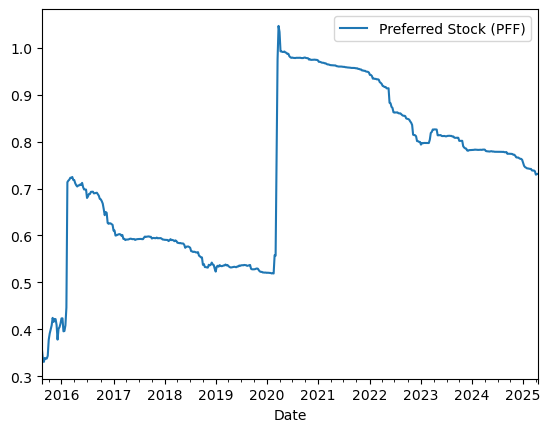

In [23]:
beta_df.plot()